In [33]:
# Global imports and settings
%matplotlib inline
from preamble import *
#%load_ext autoreload
%autoreload 2
plt.rcParams['savefig.dpi'] = 100 # Use 300 for PDF, 100 for slides
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

# Beyond linear models
Also see chapter 7

## k-Nearest Neighbor (recap)

* Building the model consists only of storing the training dataset. 
* To make a prediction, the algorithm finds the _k_ closest data points in the training dataset
* Do a vote and return the majority (or a confidence value for each class)

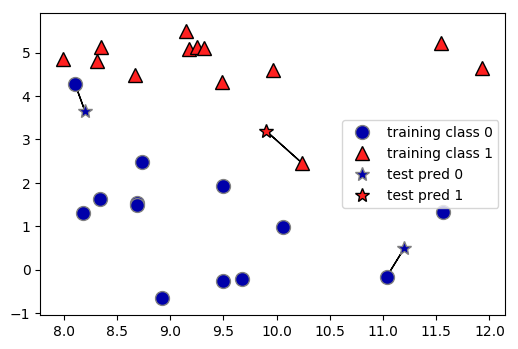

In [26]:
mglearn.plots.plot_knn_classification(n_neighbors=1)

#### Analysis
We can plot the prediction for each possible input to see the _decision boundary_ (remember?)

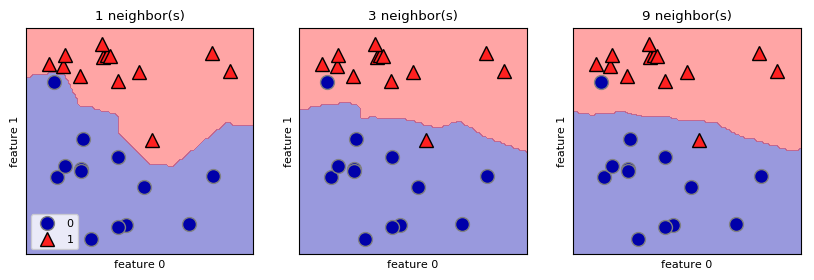

In [15]:
ml.plots.plot_kNN_overfitting(k = [1, 3, 9])

Using few neighbors corresponds to high model complexity (left), and using many neighbors corresponds to low model complexity and smoother decision boundary (right).

## k-Neighbors Regression
Return the mean target value of the $k$ nearest neighbors

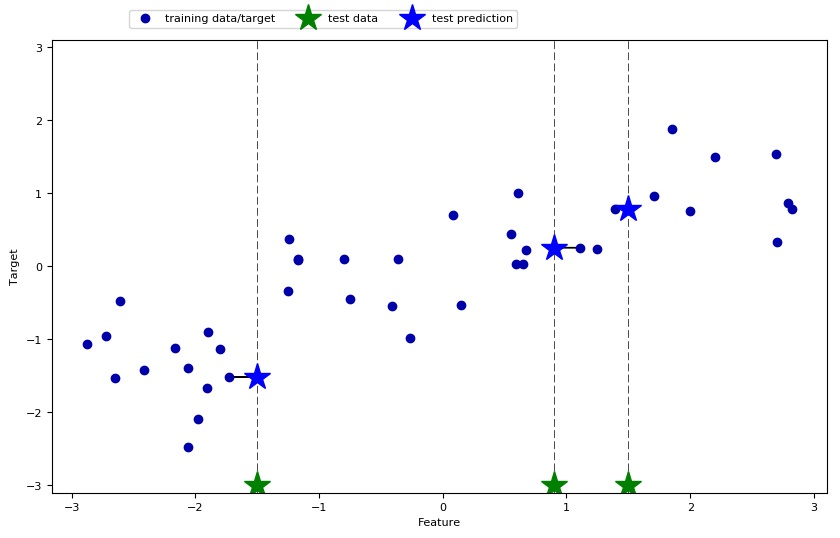

In [10]:
mglearn.plots.plot_knn_regression(n_neighbors=1)

#### Analysis
We can again output the predictions for each possible input, for different values of _k_.

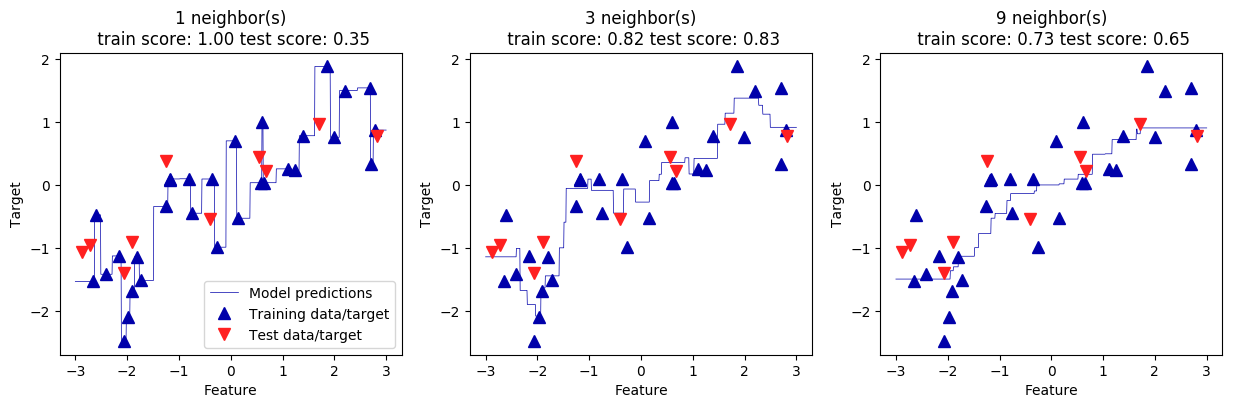

In [34]:
ml.plots.plot_kNN_regression(k = [1, 3, 9])

## Practical kNN
* Computing all distances to make a prediction is not scalable
    - Data structures such as kD-trees or ball trees help (see book section 4.7)
        - See the `search algorithm` parameter in `lazy.IBk`
    - Still not scalable for very large datasets
    - You could remove _unnecessary_ data points
        - remove training points that you can already classify correctly based on previous training points
        - doesn't work for noisy data: all noisy examples are remembered
* Performs badly with noisy data, especially for small k values
    - Solution 1: relabel all data with their kNN predictions (requires optimal $k$)
    - Solution 2: discard points often involved in misclassifications
        - Calculate a confidence bound on _success rate_ for each point
* Performs badly if many features are irrelevant
    - Curse of dimensionality: in high-dimensional spaces, distances behave differently
    - Dimensionality reduction (e.g., PCA) helps (see later)
    - You can also _weight_ attributes according to how relevant they are to predict each class
* Depending on the application, you can use different distance functions (instead of Euclidean)
    - e.g. `soft` distances: each neighbor contributes to the vote depending on how near it is
        - all points contribute, but nearest ones much more
    - also see `lazy.LWL` (locally weighted learning)

## Linear models for regression (recap)
Prediction formula for input features x. $w_i$ and b are the _model parameters_ that need to be learned.  

$\hat{y} = w_0 * x_0 + w_1 * x_1 + ... + w_p * x_p + b$

There are many different algorithms, differing in how w and b are learned from the training data.

w[0]: 0.393906  b: -0.031804


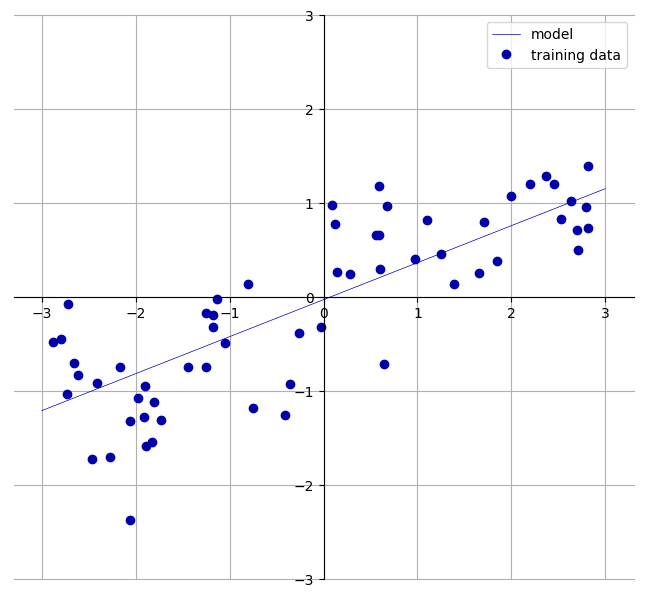

In [363]:
mglearn.plots.plot_linear_regression_wave()

### Linear Regression aka Ordinary Least Squares (recap)
* Finds the parameters w and b that minimize the _mean squared error_ between predictions and the true regression targets, y, on the training set. 
    * MSE: Sum of the squared differences (residuals) between the predictions and the true values.
    
$$\underset{w, b}{\operatorname{argmin}} \sum_{j} (\hat{y}(w, b, x^{(j)})-y^{(j)})^2$$
* Convex optimization problem with unique closed-form solution (if you have more data points than model parameters w)
* It has no hyperparameters, thus model complexity cannot be controlled.

![least squares](./images/09_least_squares.png)

### Ridge regression
* Same formula as linear regression
* Adds a penalty term $\lambda$ (ridge) to the least squares sum:
$$\underset{w, b}{\operatorname{argmin}} \sum_{j} (\hat{y}(w, b, x^{(j)})-y^{(j)})^2 + \mathbf{\lambda \sum_{i} w_i^2}$$
* Requires that the coefficients (w) are close to zero.
    * Each feature should have as little effect on the outcome as possible 
* Regularization: explicitly restrict a model to avoid overfitting.
    * The higher $\lambda$, less likely to overfit, more likely to underfit
* Type of _L2 regularization_: prefers many small weights
    * L1 regularization prefers sparsity: many weights to be 0, others large

* In WEKA:
    - `functions.LinearRegression`
    - `ridge` hyperparameter (default 1.0E-8)
    - has an option to select features (more later)

### Lasso
* Another form of regularization
* Adds a penalty term to the least squares sum:
$$\underset{w, b}{\operatorname{argmin}} \sum_{j} (\hat{y}(w, b, x^{(j)})-y^{(j)})^2 + \mathbf{\lambda \sum_{i} |w_i|}$$
* Prefers coefficients to be exactly zero (L1 regularization).
* Some features are entirely ignored by the model: automatic feature selection.
* Same parameter $\lambda$ to control the strength of regularization. 
* Not available in WEKA

## Linear models for Classification
Aims to find a (hyper)plane that separates the examples of each class.  
For binary classification (2 classes), we aim to fit the following function: 

$\hat{y} = w_0 * x_0 + w_1 * x_1 + ... + w_p * x_p + b > 0$  
    
When $\hat{y}<0$, predict class -1, otherwise predict class +1

There are many algorithms for learning linear classification models, differing in:

* Loss function: evaluate how well the linear model fits the training data
* Regularization techniques

Most common techniques:

* Logistic regression: 
    * `functions.LogisticRegression`
* Linear Support Vector Machine: 
    * `functions.SMO` with `kernel=PolyKernel` and `exponent=1`


### Logistic regression (recap)
Fits a logistic regression curve/surface to the data  
![LogisticRegression image](./images/09_logistic.png)

[Source](https://florianhartl.com/logistic-regression-geometric-intuition.html)

* Logistic regression predicts the target using the logarithm of the class probability: 
    $$Pr[1|x_1,...,x_k] \rightarrow log(\frac{Pr[1|x_1,...,x_k]}{1-Pr[1|x_1,...,x_k]})$$
* _Logit transformation_ maps [0,1] to (-Inf,Inf)
* Resulting class probability (the green curve in the figure above):
 $$Pr[1|x_1,...,x_k] = \frac{1}{1+exp(-(w_0 * x_0 + w_1 * x_1 + ... + w_p * x_p))})$$
* Parameters w are found from training data using _maximum likelihood_

###### Maximum likelihood
* Aim: maximize the probability of the observed training data with respect to the final model parameters
* We can use logaritms of probabilities and maximize conditional _log-likelihood_ instead of the product of probabilities
$$\sum_{i=1}^{n} (1-y^{(i)}) log(1-Pr[1|x_1^{(i)},...,x_k^{(i)}]) + y^{(i)} Pr[1|x_1^{(i)},...,x_k^{(i)}]$$
    * Class values $y^{(i)}$ are either 0 or 1
* Weights w_i need to be chosen to maximize log-likelihood
    * This can be done using _iterative re-weighted least squares_
    * Other optimization methods can be used as well

### Linear Support Vector Machine
Find hyperplane maximizing the _margin_ between the classes  
Defined by a set of _support vectors_ and their weights
![SVC Image](images/09_svm.png)   
Prediction is identical to weighted kNN: find the support vector that is nearest, according to a distance measure (kernel) and a weight for each support vector.

Both methods can be regularized:
* L2 regularization by default, L1 also possible
* _C_ parameter: inverse of strength of regularization
    * higher _C_: less regularization
    * penalty for misclassifying points while keeping $w_i$ close to 0

High _C_ values (less regularization): fewer misclassifications but smaller margins.

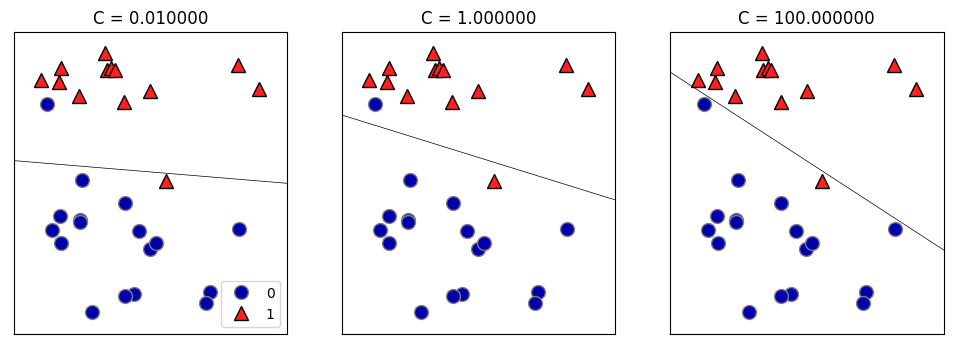

In [377]:
mglearn.plots.plot_linear_svc_regularization()

#### Linear Models for multiclass classification
Common technique: one-vs.-rest approach:

* A binary model is learned for each class vs. all other classes
* Creates as many binary models as there are classes
* Every binary classifiers makes a prediction, the one with the highest score (>0) wins

Build binary linear models:

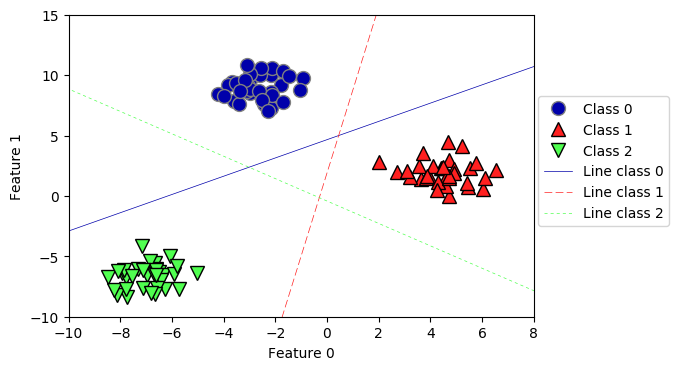

In [383]:
from sklearn.datasets import make_blobs

X, y = make_blobs(random_state=42)
linear_svm = LinearSVC().fit(X, y)

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_,
                                  mglearn.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.ylim(-10, 15)
plt.xlim(-10, 8)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1',
            'Line class 2'], loc=(1.01, 0.3))

Actual predictions (decision boundaries):

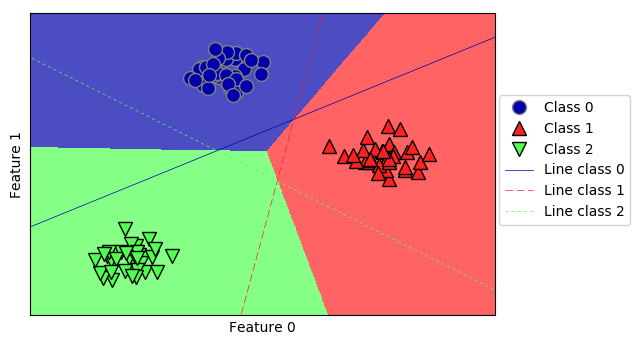

In [384]:
mglearn.plots.plot_2d_classification(linear_svm, X, fill=True, alpha=.7)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_,
                                  mglearn.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1',
            'Line class 2'], loc=(1.01, 0.3))
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

### Polynomials (nonlinear class boundaries)

We can make linear models behave more flexibly by adding polynomials of the original continuous features. 

- For a given feature x, we might want to consider $x^2$, $x^3$, $x^4$, and so on. 
- We can also add all interactions: for features x and y, we add $x*y$, $x^2*y$, $x*y^2$, and so on.

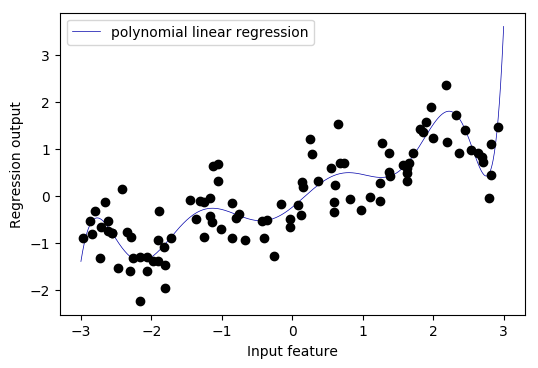

In [35]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X, y = mglearn.datasets.make_wave(n_samples=100)

# include polynomials up to x ** 10:
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)

reg = LinearRegression().fit(X_poly, y)

line_poly = poly.transform(line)
plt.plot(line, reg.predict(line_poly), label='polynomial linear regression')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

## Kernelization